# Project no. 3 Outlier Detection

**Author: Filip Kołodziejczyk 313019**


## Introduction

An outlier in data analysis is a data point that significantly deviates from other observations, which can be due to measurement variability, experimental errors, or anomalies in data generation. Proper detection and handling of outliers are crucial because they can skew statistical analyses and affect the performance of predictive models by misleading the representation of underlying trends and relationships. For instance, outliers can distort measures like mean and standard deviation and reduce the accuracy of algorithms such as linear regression. Furthermore, in a business context, outliers may signal critical issues like fraud or errors in data collection, making their identification vital for robust statistical analysis and effective decision-making.

Aim of this project is to compare different methods of outlier detection. To have some reference point, the datasets form ODDS repository will be used (multi-dimensional point datasets).

## Dataset loading

Each of the dataset as y label has information if the point is an outlier `1` or not `0`. The repository lists 30 of such datasets, but few of them were skipped. Those are:
- *Mulcross* (link not reachable)
- *Smtp* (unusual X shape)
- *Ecoli* (issues with the dataset loading)
- *Yeast* (no outlier classificaiton)
- *Seismic* (no outlier classificaiton)
- *Heart* (no outlier classificaiton)
- *ForestCover* (very large dataset, making it inconvenient for the project)

Rest of the datasets, according to the ODDS website, has the following stats:

| Dataset                        | #points           | #dim. | #outliers (%) |
|--------------------------------|-------------------|-------|---------------|
| Lympho                         | 148               | 18    | 6 (4.1%)      |
| WBC                            | 278               | 30    | 21 (5.6%)     |
| Glass                          | 214				 | 9     | 9 (4.2%)      |
| Vowels                         | 1456				 | 12    | 50 (3.4%)     |
| Cardio                         | 1831              | 21    | 176 (9.6%)    |
| Thyroid                        | 3772              | 6     | 93 (2.5%)     |
| Musk                           | 3062              | 166   | 97 (3.2%)     |
| Satimage-2                     | 5803              | 36    | 71 (1.2%)     |
| Letter Recognition             | 1600              | 32    | 100 (6.25%)   |
| Speech                         | 3686              | 400   | 61 (1.65%)    |
| Pima                           | 768               | 8     | 268 (35%)     |
| Satellite                      | 6435              | 36    | 2036 (32%)    |
| Shuttle                        | 49097             | 9     | 3511 (7%)     |
| BreastW                        | 683               | 9     | 239 (35%)     |
| Arrhythmia                     | 452               | 274   | 66 (15%)      |
| Ionosphere                     | 351               | 33    | 126 (36%)     |
| Mnist                          | 7603              | 100   | 700 (9.2%)    |
| Optdigits                      | 5216              | 64    | 150 (3%)      |
| Http (KDDCUP99)                | 567479            | 3     | 2211 (0.4%)   |
| Mammography                    | 11183             | 6     | 260 (2.32%)   |
| Annthyroid                     | 7200              | 6     | 534 (7.42%)   |
| Pendigits                      | 6870              | 16    | 156 (2.27%)   |
| Wine                           | 129               | 13    | 10 (7.7%)     |
| Vertebral                      | 240               | 6     | 30 (12.5%)    |

Let's load the data and confirm the stats.

In [2]:
import h5py
import scipy.io
import numpy as np
import os
import pandas as pd

data_dir = "../datasets/ODDS"

datasets = []
for file in os.listdir(data_dir):
    if file.endswith(".mat"):
        name = file.split(".")[0]
        try:
            data = scipy.io.loadmat(os.path.join(data_dir, file))
            X = np.array(data.get("X"))
            y = np.array(data.get("y")).flatten()
        except NotImplementedError:
            with h5py.File(os.path.join(data_dir, file), "r") as data:
                X = np.array(data.get("X"))
                y = np.array(data.get("y")).flatten()
        datasets.append({"X": X, "y": y, "name": name})

datasets = {dataset["name"]: dataset for dataset in datasets}


colnames = ["Dataset Name", "Number of Points", "Number of Features"]
data_summ = []
for dataset in datasets.values():
    data_summ.append([dataset["name"], dataset["X"].shape[0], dataset["X"].shape[1]])
df = pd.DataFrame(data_summ, columns=colnames).sort_values(by="Dataset Name")
df

,Dataset Name,Number of Points,Number of Features
16,annthyroid,7200,6
4,arrhythmia,452,274
12,breastw,683,9
2,cardio,1831,21
20,glass,214,9
17,ionosphere,351,33
7,letter,1600,32
14,lympho,148,18
19,mammography,11183,6
3,mnist,7603,100


## Outliers Detection Methods

The following methods will be used for outlier detection:
- **DBSCAN** - Density-Based Spatial Clustering of Applications with Noise
- **HDBSCAN** - Hierarchical Density-Based Spatial Clustering of Applications with Noise
- **One-class SVM** - Support Vector Machine for novelty detection
- **Isolation Forest** - Isolation Forest 'isolates' observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.
- **Local Outlier Factor** - The local outlier factor (LOF) is a measure of how isolated or how likely a data point is an outlier.
- **Genie** - Hierarchical Clustering Algorithm using Gini Index for a cluster merge


Below is the code initiating all those methods and running them against the dataset, for later results discussion. All of the methods use default parameters, except those who directly depend on the dataset size. In the case of real-world scenario, we should tune those parameters to get the best results. However, for the purpose of general overview, we want to stick to the default values, hoping that diversity of datasets will somehow average the results.

In [3]:
import genieclust
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from time import time
from tqdm.notebook import tqdm


def detect_outliers(X, model):
    y_pred = model.fit_predict(X)
    y_pred = np.where(y_pred == -1, 1, 0)

    return y_pred


outliers_pred = {}
outliers_score = {}
outliers_time = {}

with tqdm(total=len(datasets) * 6) as datasets_bar:
    for dataset in datasets.values():
        postfix_dataset_str = f"Dataset: {dataset['name']}"
        X = dataset["X"]
        min_samples = max(int(0.02 * X.shape[0]), 2)
        min_cluster_size = max(int(0.02 * X.shape[0]), 2)
        n_neighbors = min(20, X.shape[0] // 2)

        models = {
            "DBSCAN": DBSCAN(min_samples=min_samples),
            "HDBSCAN": HDBSCAN(min_cluster_size=min_cluster_size),
            "Isolation Forest": IsolationForest(),
            "One-Class SVM": OneClassSVM(),
            "LOF": LocalOutlierFactor(n_neighbors=n_neighbors),
            "Genie": genieclust.Genie(M=50),
        }

        outliers_pred[dataset["name"]] = {}
        outliers_time[dataset["name"]] = {}
        for model_name, model in models.items():
            datasets_bar.set_postfix_str(f"{postfix_dataset_str}, Model: {model_name}")

            start = time()
            y_pred= detect_outliers(X, model)
            end = time()
            outliers_pred[dataset["name"]][model_name] = y_pred
            outliers_time[dataset["name"]][model_name] = end - start

            datasets_bar.update(1)

  0%|          | 0/138 [00:00<?, ?it/s]

## Evaluation vs ground truth

Each method is compared with the ground truth provided by the ODDS, as a measure of selected method's performance. The evaluation will be done using the following metrics:
- **Accuracy** - the ratio of correctly predicted observations to the total observations
- **Precision** - the ratio of correctly predicted positive observations to the total predicted positive observations
- **Recall** - the ratio of correctly predicted positive observations to the all observations in actual class
- **F1 Score** - the weighted average of Precision and Recall

In [110]:
from IPython.display import Markdown, display
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.exceptions import UndefinedMetricWarning
import warnings

warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)
pd.set_option("display.max_colwidth", None)


def evaluate_outliers(y_true, model_pred):
    result_frames = {}
    for _, (model_name, y_pred) in enumerate(model_pred.items()):
        result_frames[model_name] = {
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "f1": f1_score(y_true, y_pred),
        }

    return pd.DataFrame(result_frames).transpose()


model_names = ["DBSCAN", "HDBSCAN", "Isolation Forest", "One-Class SVM", "LOF", "Genie"]

results = {}

for dataset in datasets.values():
    dataset_results = {}
    for model in model_names:
        dataset_results[model] = outliers_pred[dataset["name"]][model]

    results[dataset["name"]] = evaluate_outliers(dataset["y"], dataset_results)

results_df = pd.concat(results, names=["Dataset", "Model"])


accuracy_results = results_df["accuracy"].unstack()
precision_results = results_df["precision"].unstack()
recall_results = results_df["recall"].unstack()
f1_results = results_df["f1"].unstack()


def highlight_max(s):
    is_max = s == s.max()
    return ["font-weight: bold" if v else "" for v in is_max]


accuracy_results.loc["Average"] = accuracy_results.mean()
accuracy_results.loc["Std Dev"] = accuracy_results.std()

precision_results.loc["Average"] = precision_results.mean()
precision_results.loc["Std Dev"] = precision_results.std()

recall_results.loc["Average"] = recall_results.mean()
recall_results.loc["Std Dev"] = recall_results.std()

f1_results.loc["Average"] = f1_results.mean()
f1_results.loc["Std Dev"] = f1_results.std()

display(Markdown("### Accuracy Results"))
display(accuracy_results.style.apply(highlight_max, axis=1).format("{:.2%}"))

### Accuracy Results

Model,DBSCAN,HDBSCAN,Isolation Forest,One-Class SVM,LOF,Genie
Dataset,,,,,,
pima,34.90%,66.28%,67.32%,61.20%,64.45%,49.35%
wine,7.75%,78.29%,88.37%,58.14%,91.47%,62.79%
cardio,9.61%,9.61%,89.02%,59.42%,89.24%,33.97%
mnist,9.21%,9.21%,80.55%,57.49%,90.75%,29.42%
arrhythmia,14.60%,14.60%,85.40%,59.51%,85.62%,33.41%
pendigits,69.26%,60.33%,65.07%,52.24%,96.56%,34.66%
shuttle,7.15%,94.59%,95.00%,57.12%,91.20%,38.30%
letter,6.25%,71.31%,87.00%,50.00%,94.19%,37.81%
musk,3.17%,96.83%,92.85%,53.14%,96.83%,38.83%


Both Isolation Forest and LOF methods provide high accuracy, averaging above 80 % for all datasets. LOF tends to have better results but Isolation Forest is more stable. Rest of the methods are far behind them. However, the accuracy metric can be considered a poor metric for evaluating outlier detection methods, as it is highly dependent on the dataset's class distribution. In turn, outliers are rather rare. Only four datasets have more than 15% of outliers and the biggest percentage of outliers is 36%. This makes the accuracy metric biased towards the majority class and underestimates the performance of the outlier detection methods.

In [111]:
display(Markdown("### Precision Results"))

display(precision_results.style.apply(highlight_max, axis=1).format("{:.2%}"))

### Precision Results

Model,DBSCAN,HDBSCAN,Isolation Forest,One-Class SVM,LOF,Genie
Dataset,,,,,,
pima,34.90%,54.64%,58.59%,46.09%,38.10%,37.42%
wine,7.75%,0.00%,33.33%,15.62%,47.62%,0.00%
cardio,9.61%,9.61%,44.02%,19.15%,23.08%,12.33%
mnist,9.21%,9.21%,27.18%,16.70%,28.57%,10.99%
arrhythmia,14.60%,14.60%,50.00%,24.00%,51.52%,17.09%
pendigits,6.88%,5.41%,6.10%,4.54%,8.33%,1.67%
shuttle,7.15%,80.59%,59.03%,14.27%,17.29%,7.21%
letter,6.25%,14.87%,5.74%,6.25%,88.89%,8.29%
musk,3.17%,0.00%,30.70%,6.33%,0.00%,1.21%


Compared to the accuracy, precision offers better overview, as it tells how many of the detected outliers are really outliers. Thus, it is good to optimize in case when we want to avoid false positives. Indeed, the results are on the opposite side of scale compared to the accuracy. Yet, still Isolation Forest and LOF performed the best. DBSCAN and HDBSCAN tend to have very good scores in some cases, which may suggest that they may be a good performers when proper hyperparameters are set. Genie performed worst here, not achieving more than 0.5 in any dataset.

In [112]:
display(Markdown("### Recall Results"))
display(recall_results.style.apply(highlight_max, axis=1).format("{:.2%}"))

### Recall Results

Model,DBSCAN,HDBSCAN,Isolation Forest,One-Class SVM,LOF,Genie
Dataset,,,,,,
pima,100.00%,19.78%,21.64%,66.04%,2.99%,67.16%
wine,100.00%,0.00%,50.00%,100.00%,100.00%,0.00%
cardio,100.00%,100.00%,52.27%,100.00%,5.11%,96.02%
mnist,100.00%,100.00%,66.29%,90.71%,0.29%,93.86%
arrhythmia,100.00%,100.00%,7.58%,81.82%,25.76%,92.42%
pendigits,100.00%,100.00%,100.00%,100.00%,5.13%,48.08%
shuttle,100.00%,32.16%,98.43%,99.74%,6.10%,64.31%
letter,100.00%,76.00%,7.00%,50.00%,8.00%,89.00%
musk,100.00%,0.00%,100.00%,100.00%,0.00%,22.68%


Next to the precision, recall is also an interesting aspect for the outlier detection evaluation, as it tells how many of the real outliers were detected. Thus, it is worth optimizing in case when we want to detect as much of the outliers as possible. Here comes the turnover. Isolation Forest have mediocre results, while LOF results are really bad. DBSCAN and HDBSCAN have almost perfect scores for many datasets, with the DBSCAN being the best. What more interesting, is that when DBSCAN/HDBSCAN combined, all the datasets (except one), were 100% categorised perfectly. Given that those 2 work in similar way with noisy data, with proper tuning, both of them should be very sensitive for any dataset approached. SVM comes to be the best when stability desired. It does not tend to catch all the outliers often, but the results are more stable than the other methods. Genie was much better this time, promising good results when hyperparameters are set properly (it also has a possibility to catch all the outliers). When recall considered, my best choices would be DBSCAN/HDBSCAN with hyperparameters tuning, or SVM when no tuning is done.

In [113]:
display(Markdown("### F1 Results"))
display(f1_results.style.apply(highlight_max, axis=1).format("{:.2%}"))

### F1 Results

Model,DBSCAN,HDBSCAN,Isolation Forest,One-Class SVM,LOF,Genie
Dataset,,,,,,
pima,51.74%,29.04%,31.61%,54.29%,5.54%,48.06%
wine,14.39%,0.00%,40.00%,27.03%,64.52%,0.00%
cardio,17.54%,17.54%,47.79%,32.15%,8.37%,21.85%
mnist,16.86%,16.86%,38.55%,28.21%,0.57%,19.67%
arrhythmia,25.48%,25.48%,13.16%,37.11%,34.34%,28.84%
pendigits,12.87%,10.27%,11.50%,8.68%,6.35%,3.23%
shuttle,13.35%,45.97%,73.80%,24.96%,9.01%,12.97%
letter,11.76%,24.88%,6.31%,11.11%,14.68%,15.17%
musk,6.14%,0.00%,46.97%,11.91%,0.00%,2.30%


Finally, to combine the precision and recall, F1 score is used. It is a harmonic mean of precision and recall, which accounts for both false positives and false negatives. Isolation forest comes as the best one, being much better than the rest of the methods. Then there is SVM, followed by DBSCAN and HDBSCAN, which are very close to each other. LOF and Genie performed the worst. Therefore, based on the performance of the methods, Isolation Forest seems to be the best choice for the outlier detection, unless the sensitivity is the most important aspect, then DBSCAN/HDBSCAN or SVM should be considered. Nervertheless, the results for precision and f1-score are far from being satisfying, were methods struggle to get even 0.5 in most of the datasets. It would suggest either that each dataset requires method's parameters tuning, or further research is needed to find a better method for the generalized outlier detection.

## Feature to sample ratio impact

It is generally known that in many cases if there is a high feature to sample ratio, the performance of the machine learning algorithms decreases. This is due to the curse of dimensionality, which makes the data sparse and the distance between the points increases. I check if here this relationship can be easily proven.

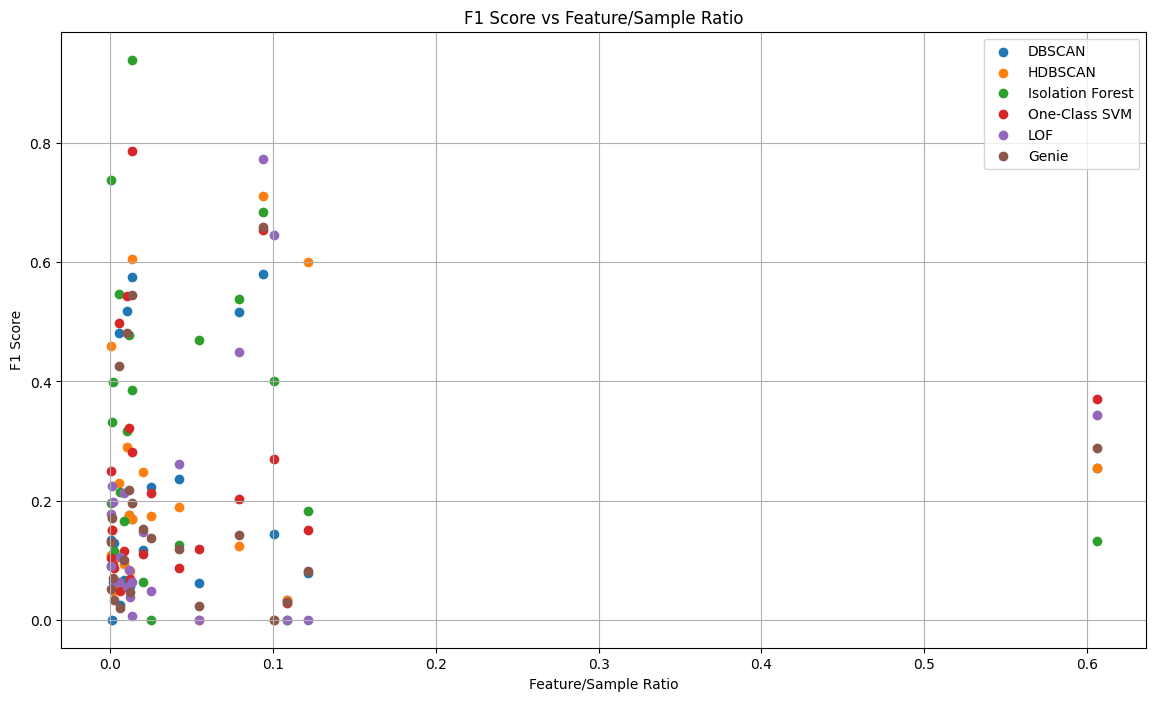

In [114]:
import matplotlib.pyplot as plt

feature_sample_ratios = {}
for dataset in datasets.values():
    feature_sample_ratios[dataset["name"].split(" ")[0]] = dataset["X"].shape[1] / dataset["X"].shape[0]

f1_ratio_results = f1_results.copy()
f1_ratio_results['Feature/Sample Ratio'] = [feature_sample_ratios[ds.split(' ')[0]] for ds in f1_ratio_results.index[:-2]] + [np.nan, np.nan]

plt.figure(figsize=(14, 8))
for model in model_names:
    ratios = [feature_sample_ratios[ds.split(' ')[0]] for ds in f1_results.index[:-2]]
    f1_scores = f1_results[model].iloc[:-2]
    plt.scatter(ratios, f1_scores, label=model)
plt.xlabel("Feature/Sample Ratio")
plt.ylabel("F1 Score")
plt.legend()
plt.title("F1 Score vs Feature/Sample Ratio")
plt.grid(True)
plt.show()


This relationship is not that easily proven by the plot provided. The hypothesis for that is pretty straightforward, there is much more than just simply a number of features and number of samples that the datasets differ. The data can be more or less noisy, the outliers can be more or less spread, the data can be more or less clustered. All of those factors can have a significant impact on the results. This experiment does not take it into account, hence no conclusions can be drawn from it. Better approach for deduction which method performs well with high feature to sample ratio would be to run the methods on the same dataset with different number of features and samples, and then compare the results. Still, I will attempt to test for the relationship between the number of features and the performance and number of samples and the performance separately, to see if there is any correlation.

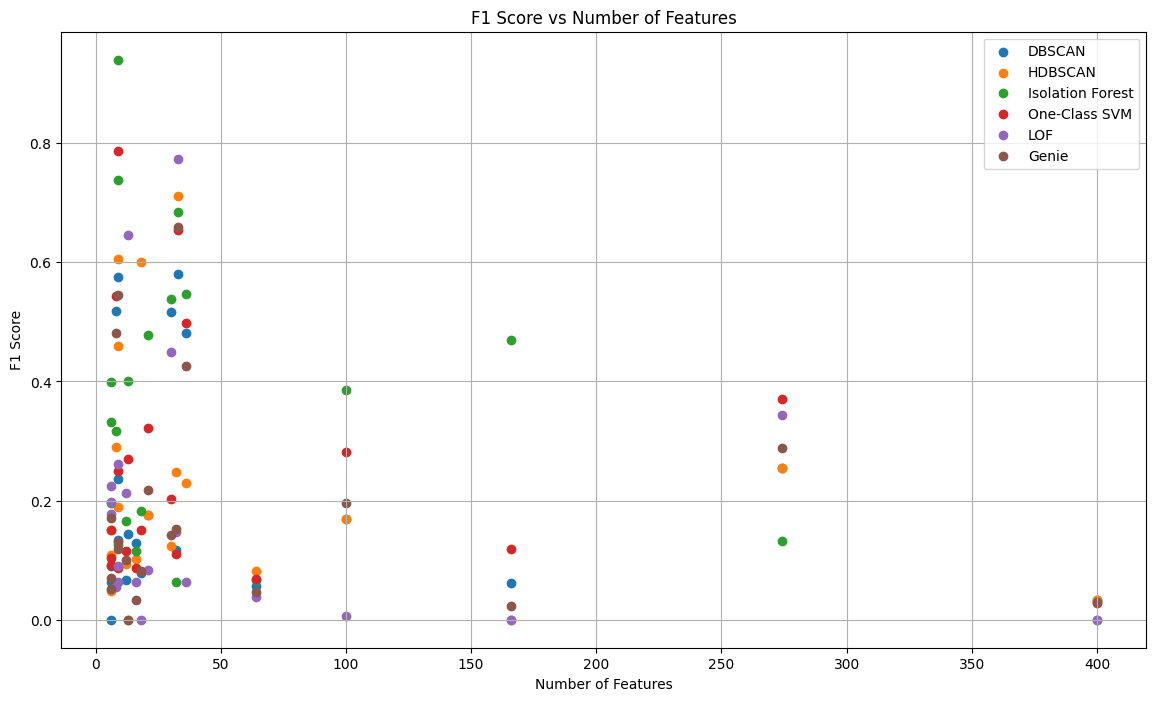

In [115]:
f1_num_feat_results = f1_results.copy().drop(["Average", "Std Dev"])
f1_num_feat_results['Feature Count'] = [ds['X'].shape[1] for ds in datasets.values()]

plt.figure(figsize=(14, 8))
for model in model_names:
    feature_counts = f1_num_feat_results["Feature Count"].iloc[:-2]
    f1_scores = f1_num_feat_results[model].iloc[:-2]
    plt.scatter(feature_counts, f1_scores, label=model)
plt.xlabel("Number of Features")
plt.ylabel("F1 Score")
plt.legend()
plt.title("F1 Score vs Number of Features")
plt.grid(True)
plt.show()

Still no emerging pattern here.

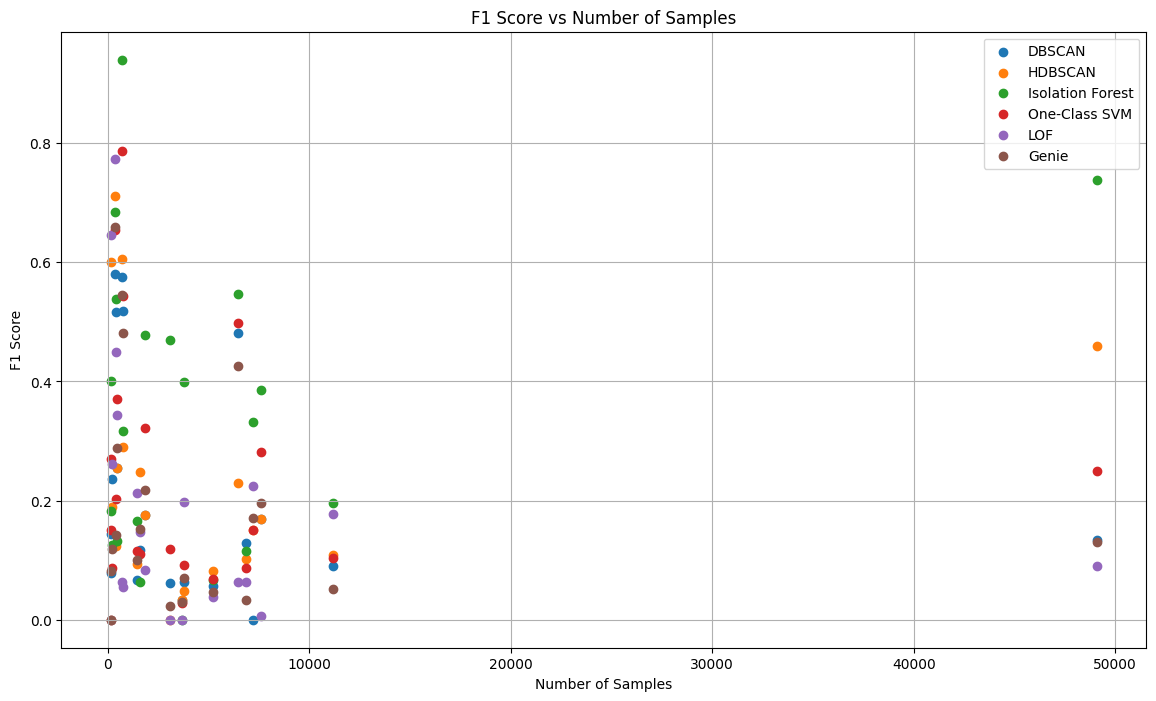

In [116]:
f1_num_sample_results = f1_results.copy().drop(["Average", "Std Dev"])
f1_num_sample_results['Sample Count'] = [ds['X'].shape[0] for ds in datasets.values()]

plt.figure(figsize=(14, 8))
for model in model_names:
    sample_counts = f1_num_sample_results["Sample Count"].iloc[:-2]
    f1_scores = f1_num_sample_results[model].iloc[:-2]
    plt.scatter(sample_counts, f1_scores, label=model)
plt.xlabel("Number of Samples")
plt.ylabel("F1 Score")
plt.legend()
plt.title("F1 Score vs Number of Samples")
plt.grid(True)
plt.show()

And once again, it is somewhat proven that the generalization is not that easy, since even dimensionality and size of the dataset are not enough to predict the performance of the outlier detection methods.

## Time efficiency

While performance like f1 of method is very important, we often need to consider the time efficiency of the method. Sometimes maximizing the performance is not worth the time it takes to compute the results. Therefore, below the time of execution of each method is also presented.

In [117]:
time_results = {}

for dataset in datasets.values():
    dataset_time_results = {}
    for model in model_names:
        dataset_time_results[model] = outliers_time[dataset["name"]][model]

    time_results[dataset["name"]] = pd.Series(dataset_time_results)

time_results_df = pd.DataFrame(time_results).transpose()

time_results_df.loc["Average"] = time_results_df.mean()
time_results_df.loc["Std Dev"] = time_results_df.std()

def highlight_min(s):
    is_min = s == s.min()
    return ["font-weight: bold" if v else "" for v in is_min]

display(Markdown("### Time Performance Results"))
display(time_results_df.style.apply(highlight_min, axis=1).format("{:.4f} s"))

### Time Performance Results

,DBSCAN,HDBSCAN,Isolation Forest,One-Class SVM,LOF,Genie
pima,0.0035 s,0.0061 s,0.1010 s,0.0193 s,0.0039 s,0.0086 s
wine,0.0009 s,0.0024 s,0.0460 s,0.0010 s,0.0009 s,0.0006 s
cardio,0.0075 s,0.0736 s,0.0526 s,0.1451 s,0.0115 s,0.0560 s
mnist,0.0733 s,6.1225 s,0.0841 s,4.1345 s,0.1176 s,4.0583 s
arrhythmia,0.0045 s,0.0632 s,0.0476 s,0.0269 s,0.0053 s,0.0507 s
pendigits,0.0506 s,0.7426 s,0.0832 s,1.8378 s,0.0716 s,0.6014 s
shuttle,0.6181 s,28.6196 s,0.2749 s,94.7689 s,1.9053 s,18.3869 s
letter,0.0739 s,0.0740 s,0.0521 s,0.1098 s,0.0356 s,0.0587 s
musk,0.0251 s,1.3465 s,0.0584 s,0.7014 s,0.0518 s,1.2414 s
thyroid,0.1612 s,0.1230 s,0.0569 s,0.4222 s,0.0405 s,0.1132 s


DBSCAN, Isolation Forest, Genie and Local Outlier Factor were quick. DBSCAN's performance is highly sensitive to the choice of epsilon and min samples. It can be computationally expensive, especially for high-dimensional datasets or datasets with many points, due to the need to calculate distances between all pairs of points within epsilon. HDBSCAN is much slower, as it implements hierarchical (nested) approach over the DBSCAN. Isolation Forest is efficient and scales well with high-dimensional data. Its performance is relatively stable, as reflected in the low standard deviation. However, the choice of the number of trees and sub-sampling size can affect its time performance. One-Class SVM can be computationally intensive, as in our experiment, particularly for large datasets (93 seconds for shuttle), due to the quadratic complexity of the underlying SVM optimization. The choice of kernel and regularization parameters significantly impacts its performance. LOF can be slow because it computes the local density of each point and compares it to the density of its neighbors, requiring pairwise distance calculations. The choice of k (number of neighbors) can significantly impact its performance. However, in the experiment, as already mentioned, the time was not an issue and still the precision was good. Genie’s performance varies widely, likely due to the nature of its balancing criterion in hierarchical clustering. It can be slower when dealing with large and complex datasets, as maintaining a balanced hierarchy requires additional computations.

## Between method comparison

While ground truth evaluation allows to pick the best performing method, it does not provide insight how methods are related to each other, what patterns do they share. For that purpose I measure pairwise similarity between the methods using the following metrics:
- **Jaccard Index** - the ratio of the size of the intersection of the sets to the size of the union of the sets. Higher the value, more similar the methods are.
- **Adjusted Rand Index** - the measure of the similarity between two data clusterings, adjusted for chance grouping of elements. The value is between -1 and 1, where 1 means that the clusterings are identical, 0 means that the clusterings are independent, and negative values mean that the clusterings are more dissimilar than by random.
- **Normalized Mutual Information** - the measure of the amount of information shared between two data clusterings, normalized (between 0 and 1). Higher the value, more similar and consistent the methods are.

For convenience, those results are summarized with the matrix representation.

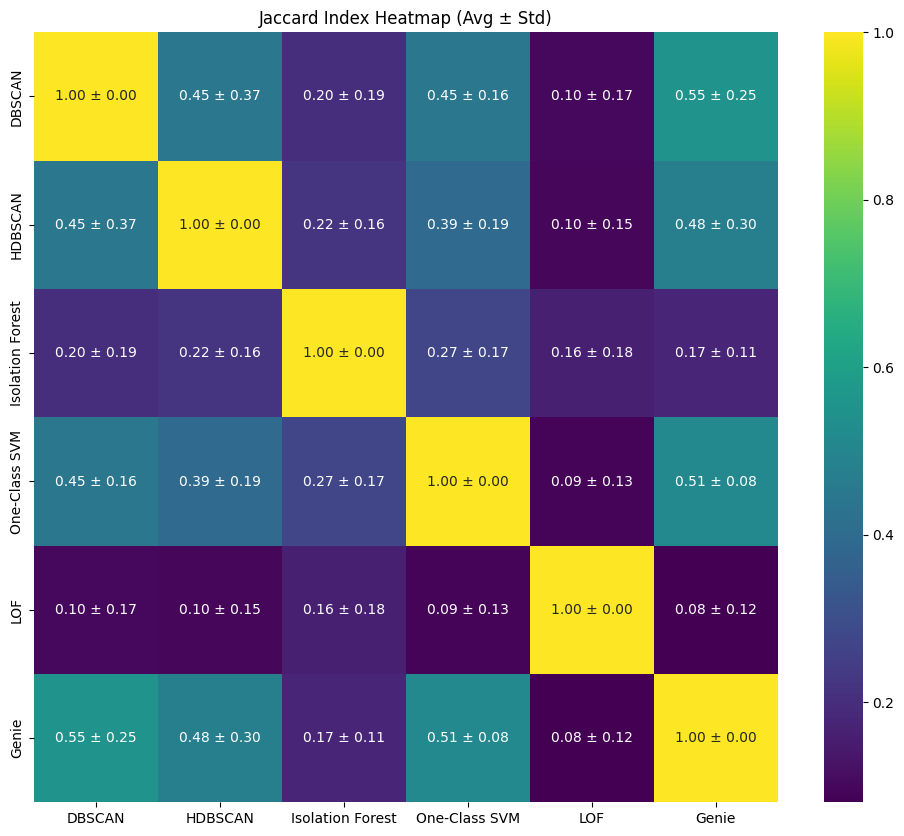

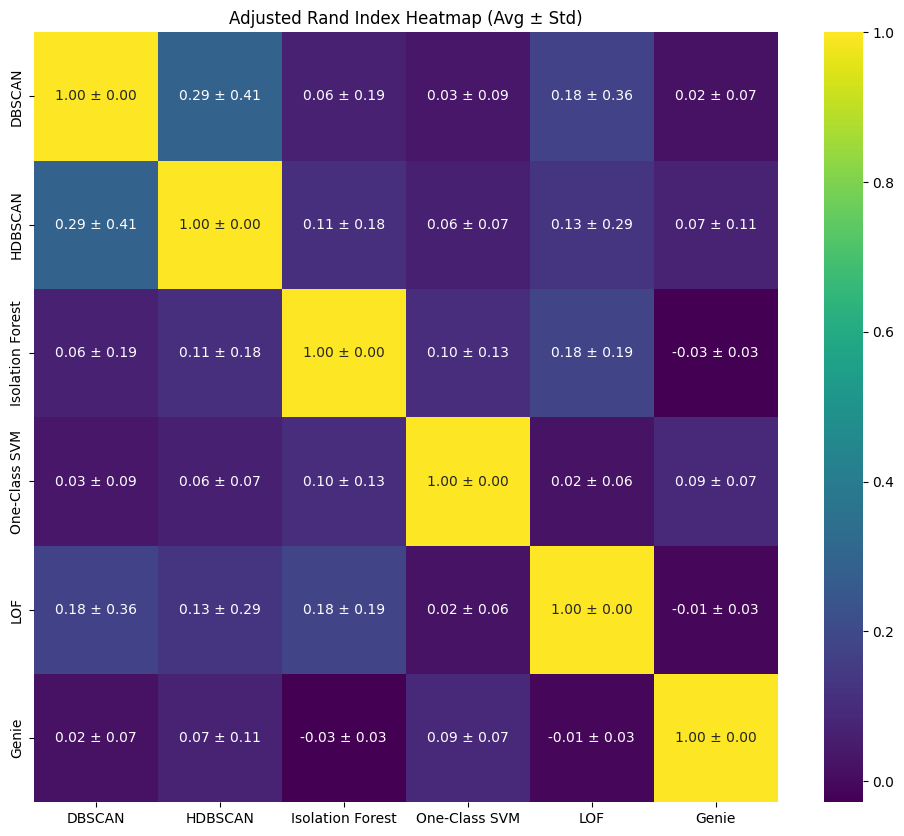

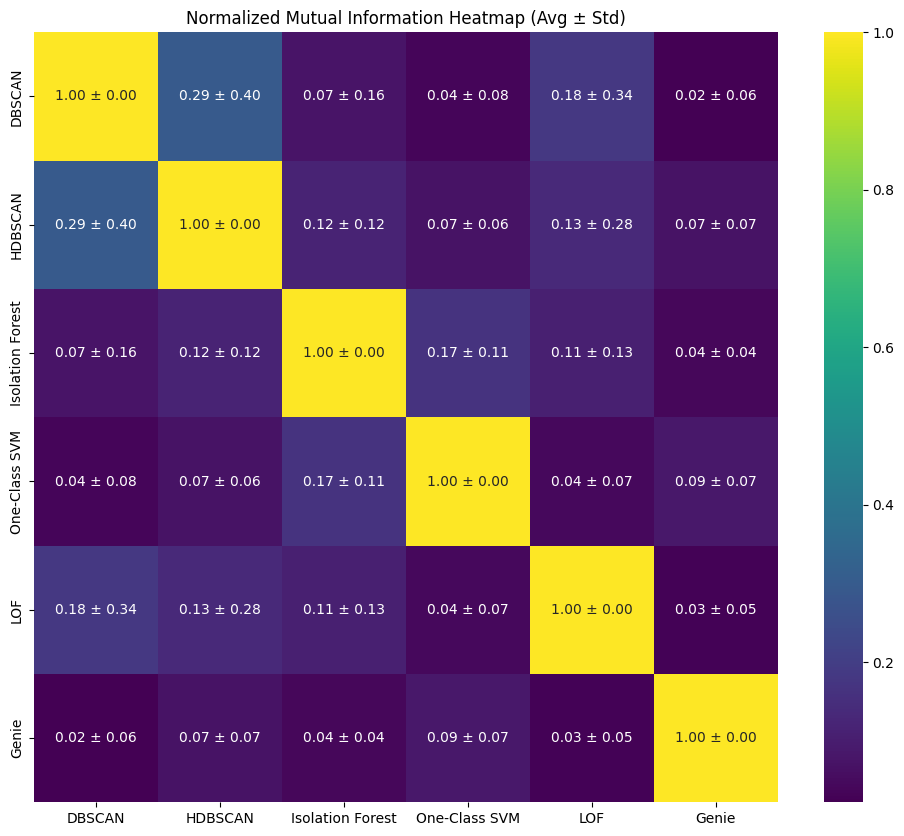

In [118]:
from sklearn.metrics import jaccard_score, adjusted_rand_score, normalized_mutual_info_score
import seaborn as sns

def calculate_similarity_metrics(predictions):
    methods = list(predictions.keys())
    num_methods = len(methods)
    jaccard_matrix = np.zeros((num_methods, num_methods))
    ari_matrix = np.zeros((num_methods, num_methods))
    nmi_matrix = np.zeros((num_methods, num_methods))

    for i, method1 in enumerate(methods):
        for j, method2 in enumerate(methods):
            if i == j:
                # Set diagonal to 1
                jaccard_matrix[i, j] = 1.0
                ari_matrix[i, j] = 1.0
                nmi_matrix[i, j] = 1.0
            else:
                jaccard_matrix[i, j] = jaccard_score(predictions[method1], predictions[method2])
                ari_matrix[i, j] = adjusted_rand_score(predictions[method1], predictions[method2])
                nmi_matrix[i, j] = normalized_mutual_info_score(predictions[method1], predictions[method2])

    return methods, jaccard_matrix, ari_matrix, nmi_matrix

all_matrices = {"Jaccard Index": [], "Adjusted Rand Index": [], "Normalized Mutual Information": []}

for dataset_name, dataset_preds in outliers_pred.items():
    methods, jaccard_matrix, ari_matrix, nmi_matrix = calculate_similarity_metrics(dataset_preds)
    all_matrices["Jaccard Index"].append(jaccard_matrix)
    all_matrices["Adjusted Rand Index"].append(ari_matrix)
    all_matrices["Normalized Mutual Information"].append(nmi_matrix)

def aggregate_matrices(all_matrices, metric):
    avg_matrix = np.mean(all_matrices[metric], axis=0)
    std_matrix = np.std(all_matrices[metric], axis=0)
    return avg_matrix, std_matrix

aggregated_matrices = {metric: aggregate_matrices(all_matrices, metric) for metric in all_matrices.keys()}

dfs_avg = {}
dfs_combined = {}
for metric, (avg, std) in aggregated_matrices.items():
    dfs_avg[metric] = pd.DataFrame(avg, index=methods, columns=methods)
    combined_matrix = np.zeros(avg.shape, dtype=object)
    for i in range(avg.shape[0]):
        for j in range(avg.shape[1]):
            combined_matrix[i, j] = f"{avg[i, j]:.2f} ± {std[i, j]:.2f}"
    dfs_combined[metric] = pd.DataFrame(combined_matrix, index=methods, columns=methods)

for metric in all_matrices.keys():
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(dfs_avg[metric], annot=dfs_combined[metric], fmt='', cmap='viridis')
    plt.title(f'{metric} Heatmap (Avg ± Std)')
    plt.show()

According to the results, each method is unique in its own way. Even DBSCAN and HDBSCAN result it significantly different results, despite the fact that they are based on the similar idea. Still the Adjusted Rand Index and Normalized Mutual Information is the highest between them among the rest. Jaccard index present that DBSCAN, HDBSCAN, One-Class SVM and Genie are similar to some extent, while LOF and Isolation Forest are the most different from the rest.

## Conclusions

Outlier detection is critical in data analysis to identify anomalies that may distort statistical analyses or indicate significant deviations in the data, such as fraud or errors. This project aimed to compare various outlier detection methods using datasets from the ODDS repository, focusing on their effectiveness and efficiency. The methods compared included DBSCAN, HDBSCAN, Isolation Forest, One-Class SVM, LOF, and Genie.

The evaluation metrics included accuracy, precision, recall, and F1-score, along with the execution time for each method on each dataset. Additionally, the influence of the number of features on the F1-score was analyzed. The F1-score is crucial as it balances precision and recall, offering a single measure of effectiveness. Isolation Forest consistently showed high F1-scores, indicating highest performance across various datasets compared to different methods, having 0.31 $\pm$ 0.24 F1-score on average. While accuracy is useful, it can be misleading due to the imbalanced nature of outlier detection problems, where there are few outliers compared to inliers. Precision and recall provided additional insights, especially in understanding the trade-offs between detecting true outliers and avoiding false positives.

Time performance varied across methods. All the methods in the setup used in experiment were rather fast, except of HDBSCAN and SVM.

There wasn't a clear relationship between the number of features and the performance of outlier detection methods. It is caused likely by the fact that the datasets differ in many other aspects, such as noise, outliers spread, clustering, etc. The same applies to the number of samples and the ratio of features to samples.

Similarity metrics such as Jaccard Index, Adjusted Rand Index (ARI), and Normalized Mutual Information (NMI) were used to compare the similarity between different methods. None of the methods indicated high resemblance to each other, suggesting that each method has unique characteristics and performance. T

For general use, Isolation Forest is recommended. When the recall is top priority, then the most robust are DBSCAN and SVM, where the latter in cost of slightly lower average result, is more consistent. However, probably the most important part of accurate outlier detection is the proper tuning of the hyperparameters, adapting the method to the specificity of dataset, which was not done in this experiment.

Future work could include further exploration of hyperparameter optimization for each method to enhance performance. Incorporating other evaluation metrics, such as ROC-AUC, could provide a more comprehensive assessment.